# Adaptation of the ABM shelling modelling on the Netherlands

This notebook is directly inspired by the [Schelling segregation model example](https://github.com/projectmesa/mesa-schelling-example) made available by the Mesa package, and the [basic tutorial](https://mesa-geo.readthedocs.io/en/latest/tutorials/intro_tutorial.html#getting-started) of Mesa-Geo: GIS Extension for Mesa Agent-Based Modeling.

In [1]:
import random
import mesa
import mesa_geo as mg
import geopandas as gpd

## Load the GIS data of the Netherlands

We can get GIS info about the Netherlands from the [Princeton University Library](https://maps.princeton.edu/catalog/stanford-st293bj4601)

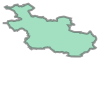

In [2]:
gdf = gpd.read_file("netherlands-geo.json")
# Access the geometry information of the Netherlands
gdf.geometry.values[1]

#### From the basic example of the mesa-geo package

Create Agent and Model classes

In [3]:
class State(mg.GeoAgent):
    def __init__(self, unique_id, model, geometry, crs):
        super().__init__(unique_id, model, geometry, crs)


class GeoModel(mesa.Model):
    def __init__(self):
        self.space = mg.GeoSpace()

        ac = mg.AgentCreator(agent_class=State, model=self)
        agents = ac.from_GeoJSON(GeoJSON=gdf, unique_id="name_1")
        self.space.add_agents(agents)

Init the model

In [4]:
# init model
m = GeoModel()

/Users/evaviviani/src/mesa-geo/mesa_geo/geospace.py:138: UserWarning: Converting State from crs EPSG:4326 to the crs of GeoSpace - EPSG:3857. Please check your crs settings if this is unintended, or set `GeoSpace.warn_crs_conversion` to `False` to suppress this warning message.
  warnings.warn(


Agents in this example are Dutch's regions. These are contained in the GIS file, together with their spatial configuration and stored in the `unique_id` column.

This region is called: Overijssel


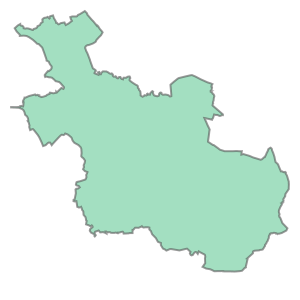

In [6]:
agent = m.space.agents[1]
print(f"This region is called: " + str(agent.unique_id))
agent.geometry


We can get `neighbours` which in this case are regions confining the above one via the `get_neighbors` function

In [7]:
neighbours = m.space.get_neighbors(agent)
print([a.unique_id for a in neighbours])


['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'IJsselmeer']


Or we can get confining regions which are within a specific distance, e.g., 600000.

In [8]:
[a.unique_id for a in m.space.get_neighbors_within_distance(agent, 600000)]


['Zeeland',
 'Zeeuwse meren',
 'Zuid-Holland',
 'Noord-Holland',
 'Noord-Brabant',
 'Utrecht',
 'IJsselmeer',
 'Flevoland',
 'Friesland',
 'Limburg',
 'Gelderland',
 'Overijssel',
 'Drenthe',
 'Groningen']

## Adapt the schelling agent example from mesa with the geo info of the Netherlands

From the Mesa schelling model example, we add the GIS info with mesa-geo

In [11]:
class SchellingAgent(mg.GeoAgent):
    """Schelling segregation agent."""

    def __init__(self, unique_id, model, geometry, crs, agent_type=None):
        """Create a new Schelling agent.
        Args:
            unique_id: Unique identifier for the agent.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        """
        super().__init__(unique_id, model, geometry, crs)
        self.atype = agent_type

    def step(self):
        """Advance agent one step."""
        print("Hi, I am agent " + str(self.unique_id) + " And my happiness is " + str(self.model.happy))
        similar = 0
        different = 0
        neighbors = self.model.space.get_neighbors(self)
        if neighbors:
            for neighbor in neighbors:
                if neighbor.atype is None:
                    continue
                elif neighbor.atype == self.atype:
                    similar += 1
                else:
                    different += 1

        # If unhappy, move:
        if similar < different:
            # Select an empty region
            empties = [a for a in self.model.space.agents if a.atype is None]
            # Switch atypes and add/remove from scheduler
            new_region = random.choice(empties)
            new_region.atype = self.atype
            self.model.schedule.add(new_region)
            self.atype = None
            self.model.schedule.remove(self)
        else:
            self.model.happy += 1

    def __repr__(self):
        return "Agent " + str(self.unique_id)


class GeoSchelling(mesa.Model):
    """Model class for the Schelling segregation model."""

    def __init__(self, density=0.6, minority_pc=0.2, export_data=False):
        
        if density>1:
            raise ValueError('density should be < 1.')
        
        if minority_pc > 1:
            raise ValueError('mnority_pc should be < 1.')
            
        self.density = density
        self.minority_pc = minority_pc
        self.export_data = export_data

        self.schedule = mesa.time.RandomActivation(self)
        self.space = mg.GeoSpace(warn_crs_conversion=False)

        self.happy = 0
        self.datacollector = mesa.DataCollector({"happy": "happy"})

        self.running = True

        # Set up the grid with patches for every NUTS region
        ac = mg.AgentCreator(SchellingAgent, model=self)
        agents = ac.from_file("netherlands-geo.json")
        self.space.add_agents(agents)

        # Set up agents
        for agent in agents:
            if random.random() < self.density:
                if random.random() < self.minority_pc:
                    agent.atype = 1
                else:
                    agent.atype = 0
                self.schedule.add(agent)

    def export_agents_to_file(self) -> None:
        self.space.get_agents_as_GeoDataFrame(agent_cls=SchellingAgent).to_crs(
            "epsg:4326"
        ).to_file("output/schelling_agents_nl.geojson", driver="GeoJSON")

    def step(self):
        """Run one step of the model.
        If All agents are happy, halt the model.
        """
        self.happy = 0  # Reset counter of happy agents
        self.schedule.step()
        self.datacollector.collect(self)

        if self.happy == self.schedule.get_agent_count():
            self.running = False

        if not self.running and self.export_data:
            self.export_agents_to_file()

### Run the model and print the results

In [12]:
n_regions = len(neighbours)
n_agents = 4  
happiness_th = 0.9
print("density = " + str(n_agents/n_regions))

model = GeoSchelling(density = n_agents/n_regions, minority_pc = happiness_th)
for i in range(5):
    model.step()

density = 0.8
Hi, I am agent 7 And my happiness is 0
Hi, I am agent 10 And my happiness is 1
Hi, I am agent 1 And my happiness is 2
Hi, I am agent 12 And my happiness is 3
Hi, I am agent 8 And my happiness is 4
Hi, I am agent 2 And my happiness is 5
Hi, I am agent 0 And my happiness is 6
Hi, I am agent 13 And my happiness is 7
Hi, I am agent 6 And my happiness is 7
Hi, I am agent 5 And my happiness is 8
Hi, I am agent 4 And my happiness is 9
Hi, I am agent 11 And my happiness is 10
Hi, I am agent 8 And my happiness is 0
Hi, I am agent 4 And my happiness is 1
Hi, I am agent 12 And my happiness is 2
Hi, I am agent 5 And my happiness is 3
Hi, I am agent 0 And my happiness is 4
Hi, I am agent 6 And my happiness is 5
Hi, I am agent 10 And my happiness is 6
Hi, I am agent 2 And my happiness is 7
Hi, I am agent 1 And my happiness is 8
Hi, I am agent 7 And my happiness is 9
Hi, I am agent 3 And my happiness is 10
Hi, I am agent 11 And my happiness is 10
Hi, I am agent 1 And my happiness is 0
H

In sum, we can easily extend the Mesa package with Mesa-Geo to adapt it to the Netherlands geo info, in case we would need it. This demonstrate the easiness by which we can use Mesa extentions.